### Import

In [1]:
from tqdm import tqdm; tqdm.pandas()
from collections import defaultdict
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from pytorch_model_summary import summary

from rawdata import RawData, Preprocess
from data import DataInfo, Dataset, collate_fn
from data import NoneScaler, LogScaler, CustomLabelEncoder

device = torch.device("cuda")

### Config

In [2]:
test_mode = False

# Raw data
is_prep_data_exist = True

# Data loader
MIN_MEANINGFUL_SEQ_LEN = 100
MAX_SEQ_LEN = 365
PRED_LEN = 100
is_non_zero = False

modality_info = {
    "group": ["article_id", "sales_channel_id"],
    "target": ["sales"],
    "temporal": ["dow", "month", "holiday", "price", "year"],
}
processing_info = {
    "scaling_cols": {"sales": StandardScaler, "price": StandardScaler, "year":NoneScaler},
    "embedding_cols": [ "dow", "month", "holiday"],
}

# Model
batch_size = 32
nhead = 4
dropout = 0.1
is_identical = False

d_model = {"encoder":128, "decoder":64}
d_ff = {"encoder":128, "decoder":64}
num_layers = {"encoder":2, "decoder":2}
remain_rto = {"target": 0.25, "temporal":0.25, "cat":1}

# Data

### Raw data

In [3]:
if test_mode:
    df_preprocessed = pd.read_parquet("src/df_preprocessed_test.parquet")
else:
    if not is_prep_data_exist:
        rawdata = RawData()
        df_trans, df_meta, df_holiday = rawdata.get_raw_data()
        preprocess = Preprocess(df_trans, df_meta, df_holiday)
        df_preprocessed = preprocess.main()
    else:
        df_preprocessed = pd.read_parquet("src/df_preprocessed.parquet")

### Dataset

In [4]:
df_train = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1)]
df_valid = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1 + PRED_LEN)]

data_info = DataInfo(modality_info, processing_info)

In [5]:
train_dataset = Dataset(df_train, data_info, remain_rto, is_non_zero)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info), pin_memory=True, num_workers=16, prefetch_factor=4)

for data in train_dataloader:
    [print(key, val.shape) for key, val in data.items()]
    break

100%|██████████| 29388/29388 [00:01<00:00, 19394.91it/s]
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


sales torch.Size([32, 365, 1])
target_valid_idx torch.Size([32, 365])
sales_remain_idx torch.Size([32, 91])
sales_masked_idx torch.Size([32, 274])
sales_revert_idx torch.Size([32, 365])
sales_remain_padding_mask torch.Size([32, 91])
sales_masked_padding_mask torch.Size([32, 274])
sales_revert_padding_mask torch.Size([32, 365])
dow torch.Size([32, 365])
dow_remain_idx torch.Size([32, 91])
dow_masked_idx torch.Size([32, 274])
dow_revert_idx torch.Size([32, 365])
dow_remain_padding_mask torch.Size([32, 91])
dow_masked_padding_mask torch.Size([32, 274])
dow_revert_padding_mask torch.Size([32, 365])
month torch.Size([32, 365])
month_remain_idx torch.Size([32, 91])
month_masked_idx torch.Size([32, 274])
month_revert_idx torch.Size([32, 365])
month_remain_padding_mask torch.Size([32, 91])
month_masked_padding_mask torch.Size([32, 274])
month_revert_padding_mask torch.Size([32, 365])
holiday torch.Size([32, 365])
holiday_remain_idx torch.Size([32, 91])
holiday_masked_idx torch.Size([32, 274])


# Train

### Model

In [6]:
# def get_positional_encoding(d_model, seq_len=1000):
#     position = torch.arange(seq_len).reshape(-1,1)
#     i = torch.arange(d_model)//2
#     exp_term = 2*i/d_model
#     div_term = torch.pow(10000, exp_term).reshape(1, -1)
#     pos_encoded = position / div_term

#     pos_encoded[:, 0::2] = torch.sin(pos_encoded[:, 0::2])
#     pos_encoded[:, 1::2] = torch.cos(pos_encoded[:, 1::2])

#     return pos_encoded

def get_positional_encoding(d_hidn, n_seq=1000):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    res = torch.tensor(sinusoid_table).to(torch.float32)
    print(res.dtype)
    return res

class NoneEmbedding(torch.nn.Module):
    def forward(self, data):
        if len(data.shape) == 3:
            return data.to(torch.float)
        else:
            return data.unsqueeze(-1).to(torch.float)

class NumericalEmbedding(torch.nn.Module):
    def __init__(self, d_model, is_identical):
        super().__init__()
        self.linear_embedding = torch.nn.Linear(1, d_model)
        
        if is_identical: self.linear_embedding = NoneEmbedding()
    
    def forward(self, data):
        return self.linear_embedding(data)

class CategoricalEmbedding(torch.nn.Module):
    def __init__(self, num_cls, d_model, is_identical):
        super().__init__()
        self.embedding = torch.nn.Embedding(num_cls, d_model)
        
        if is_identical: self.embedding = NoneEmbedding()
    
    def forward(self, data):
        return self.embedding(data)

class DynamicOutput(torch.nn.Module):
    def __init__(self, col, data_info, label_encoder_dict, d_model):
        super().__init__()
        if col in data_info.processing_info["scaling_cols"]:
            self.output = torch.nn.Sequential(
                            # torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, 1)
                            )
        elif col in data_info.processing_info["embedding_cols"]:
            num_cls = label_encoder_dict[col].get_num_cls()
            self.output = torch.nn.Sequential(
                            # torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, num_cls)
                            )
    
    def forward(self, data):
        
        return self.output(data)

class CustomDecoder(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, activation, dropout):
        super().__init__()
        self.cross_attn = torch.nn.MultiheadAttention(d_model, num_heads, dropout, batch_first=True)
        self.mlp = torch.nn.Linear(d_model, d_model)
        self.transformer = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model, nhead, d_ff, dropout, activation, batch_first=True), 2)

        self.layernorm_tgt = torch.nn.LayerNorm(d_model)
        self.layernorm_mem = torch.nn.LayerNorm(d_model)

        self.layernorm1 = torch.nn.LayerNorm(d_model)
        self.layernorm2 = torch.nn.LayerNorm(d_model)

    
    def _get_padding_mask(self, padding_mask, memory, device):
        padding_mask_li = []
        for col, val in memory.items():
            padding_mask_li.append(padding_mask[f"{col}_revert_padding_mask"])
        
        result = torch.cat(padding_mask_li, dim=1).to(device)
        result = torch.where(result == 1, 0, -torch.inf)
        return result
    
    def forward(self, col, tgt, memory, padding_mask, device):
        key_padding_mask = self._get_padding_mask(padding_mask, memory, device)
        memory = torch.cat(list(memory.values()), dim=1)
        
        tgt = self.layernorm_tgt(tgt)
        memory = self.layernorm_mem(memory)
        
        cross_attn, attn_weight = self.cross_attn(query=tgt, key=memory, value=memory, key_padding_mask=key_padding_mask)

        cross_attn = self.layernorm1(tgt + cross_attn)
        mlp = self.mlp(cross_attn)

        padding_mask = padding_mask[f"{col}_revert_padding_mask"]
        padding_mask = torch.where(padding_mask == 1, 0, -torch.inf)
        transformer = self.transformer(mlp, src_key_padding_mask=padding_mask)

        transformer = self.layernorm2(transformer + mlp)
        
        return transformer

1==1

True

In [7]:
class Transformer(torch.nn.Module):
    def __init__(self, data_info, label_encoder_dict,
                    d_model, num_layers, nhead, d_ff, dropout,
                    is_identical=False):
        super().__init__()
        activation = "gelu"
        self.data_info, self.label_encoder_dict, self.is_identical = data_info, label_encoder_dict, is_identical

        # 1. Embedding
        self.numerical_embedding_dict = self._init_numerical_embedding_dict(d_model["encoder"])
        self.categorical_embedding_dict = self._init_categorical_embedding_dict(d_model["encoder"])

        # 3. Apply remain positional encoding
        self.encoder_pos_enc = torch.nn.Parameter(get_positional_encoding(d_model["encoder"]), requires_grad=False)  if not self.is_identical else torch.nn.Parameter(torch.zeros(1000, 1))

        # 4. Apply modality embedding
        self.num_modality = len(self.data_info.modality_info["target"] + self.data_info.modality_info["temporal"])
        self.encoder_mod_emb = torch.nn.Embedding(self.num_modality, d_model["encoder"])  if not self.is_identical else NoneEmbedding()

        # 5. Encoding
        self.encoder = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model=d_model["encoder"], nhead=nhead, dim_feedforward=d_ff["encoder"], dropout=dropout, batch_first=True, activation=activation), num_layers["encoder"])  if not self.is_identical else NoneEmbedding()
        self.to_decoder_dim = torch.nn.Linear(d_model["encoder"], d_model["decoder"])  if not self.is_identical else NoneEmbedding()

        # 7. Revert
        self.mask_token = torch.nn.Parameter(torch.rand(1, d_model["decoder"])) if not self.is_identical else torch.nn.Parameter(torch.zeros(1, 1) + 99)

        # 8. Apply revert positional encoding
        self.decoder_pos_enc = torch.nn.Parameter(get_positional_encoding(d_model["decoder"]), requires_grad=False)  if not self.is_identical else torch.nn.Parameter(torch.zeros(1000, 1))

        # 9. Apply modality embedding
        self.decoder_mod_emb = torch.nn.Embedding(self.num_modality, d_model["decoder"])  if not self.is_identical else NoneEmbedding()

        # 10. Decoding
        self.custom_decoder = self._init_custom_deocder_dict(d_model["decoder"], nhead, d_ff["decoder"], activation, dropout)

        # 11. Output
        self.temporal_output = self._init_temporal_output(d_model["decoder"])
        
    def forward(self, input_data_dict, remain_rto, device):
        # 0. Data to gpu
        data_dict, idx_dict, padding_mask_dict = self._to_gpu(input_data_dict, device)

        # 1. Embedding
        embedding_dict = {}
        embedding_dict.update(self._apply_numerical_embedding(data_dict))
        embedding_dict.update(self._apply_categorical_embedding(data_dict))

        # 2. Apply remain
        temporal_remain = self._apply_temporal_remain(embedding_dict, idx_dict)

        # 3. Apply remain positional encoding
        temporal_remain = self._apply_remain_temporal_positional_encoding(temporal_remain, idx_dict, self.encoder_pos_enc)

        # 4. Apply modality embedding
        temporal_remain = self._apply_modality_embedding(temporal_remain, self.encoder_mod_emb, device)

        # 5. Encoding
        encoder_padding_mask = self._get_padding_mask(padding_mask_dict, temporal_remain, device, mode="remain")
        concat = torch.cat(list(temporal_remain.values()), dim=1)

        encoded = self.encoder(concat, src_key_padding_mask=encoder_padding_mask)
        encoded = self.to_decoder_dim(encoded)

        # 6. Split
        temporal_encoded = self._split_modalities(encoded, temporal_remain)

        # 7. Revert
        temporal_reverted = self._apply_temporal_revert(temporal_encoded, idx_dict, padding_mask_dict)

        # 8. Apply revert positional encoding
        temporal_reverted = self._apply_reverted_temporal_positional_encoding(temporal_reverted, idx_dict, self.decoder_pos_enc)

        # 9. Apply modality embedding
        temporal_reverted = self._apply_modality_embedding(temporal_reverted, self.decoder_mod_emb, device)

        # 10. Decoding
        temporal_decoded = self._apply_custom_decoder(temporal_reverted, padding_mask_dict, device)

        # 12. Ouptut
        temporal_output = self._apply_temporal_output(temporal_decoded)

        return temporal_output

    
    def _to_gpu(self, data, device):
        data_dict = {}
        idx_dict = {}
        padding_mask_dict = {}

        for col in data.keys():
            if col.endswith("padding_mask"):
                padding_mask_dict[col] = data[col].to(device)
            elif col.endswith("idx"):
                idx_dict[col] = data[col].to(device)
            elif col in self.data_info.modality_info["target"] + self.data_info.modality_info["temporal"]:
                data_dict[col] = data[col].to(device)
        
        return data_dict, idx_dict, padding_mask_dict
    
    def _init_numerical_embedding_dict(self, d_model):
        result_dict = {}
        target_cols = self.data_info.processing_info["scaling_cols"]
        for col in target_cols:
            result_dict[col] = NumericalEmbedding(d_model, self.is_identical) if not self.is_identical else NoneEmbedding()
        
        return torch.nn.ModuleDict(result_dict)

    def _init_categorical_embedding_dict(self, d_model):
        result_dict = {}
        target_cols = self.data_info.processing_info["embedding_cols"]
        for col in target_cols:
            num_cls = self.label_encoder_dict[col].get_num_cls()
            result_dict[col] = CategoricalEmbedding(num_cls, d_model, self.is_identical) if not self.is_identical else NoneEmbedding()
        
        return torch.nn.ModuleDict(result_dict)
    
    def _init_temporal_output(self, d_model):
        result_dict = {}
        for col in self.data_info.modality_info["target"] + self.data_info.modality_info["temporal"]:
            result_dict[col] = DynamicOutput(col, self.data_info, self.label_encoder_dict, d_model) if not self.is_identical else NoneEmbedding()
        
        return torch.nn.ModuleDict(result_dict)

    def _init_custom_deocder_dict(self, d_model, num_heads, d_ff, activation, dropout):
        result_dict = {}
        target_cols = self.data_info.modality_info["target"] + self.data_info.modality_info["temporal"]
        for col in target_cols:
            result_dict[col] = torch.nn.ModuleList([CustomDecoder(d_model, num_heads, d_ff, activation, dropout),
                                                    CustomDecoder(d_model, num_heads, d_ff, activation, dropout),
                                                    # CustomDecoder(d_model, num_heads, d_ff, activation, dropout),
                                                    # CustomDecoder(d_model, num_heads, d_ff, activation, dropout)
                                                    ])
        return torch.nn.ModuleDict(result_dict)


    def _apply_numerical_embedding(self, data):
        result_dict = {}
        target_cols = self.data_info.processing_info["scaling_cols"]
        
        for col in target_cols:
            result_dict[col] = self.numerical_embedding_dict[col](data[col])
        
        return result_dict

    def _apply_categorical_embedding(self, data):
        result_dict = {}
        target_cols = self.data_info.processing_info["embedding_cols"]
        for col in target_cols:
            result_dict[col] = self.categorical_embedding_dict[col](data[col])
        
        return result_dict

    def _apply_temporal_remain(self, embedding_dict, idx_dict):
        result_dict = {}
        valid_idx = idx_dict["target_valid_idx"]
        for col, val in embedding_dict.items():
            # Get valid data
            val = torch.gather(val, index=valid_idx.unsqueeze(-1).repeat(1, 1, val.shape[-1]), dim=1)
            
            # Get remain data
            remain_idx = idx_dict[f"{col}_remain_idx"].unsqueeze(-1).repeat(1, 1, val.shape[-1])
            val = torch.gather(val, index=remain_idx, dim=1)

            result_dict[col] = val
        return result_dict

    def _apply_remain_temporal_positional_encoding(self, temporal_embedding, idx_dict, pos_enc):
        result_dict = {}
        valid_idx = idx_dict["target_valid_idx"].unsqueeze(-1).repeat(1, 1, pos_enc.shape[-1])
        pos_enc = pos_enc.unsqueeze(0).repeat(valid_idx.shape[0], 1, 1)
        pos_enc = torch.gather(pos_enc, index=valid_idx, dim=1)
        
        for col, val in temporal_embedding.items():
            # Get remain pos_enc
            remain_idx = idx_dict[f"{col}_remain_idx"].unsqueeze(-1).repeat(1, 1, pos_enc.shape[-1])
            remain_pos_enc = torch.gather(pos_enc, index=remain_idx, dim=1)
            
            result_dict[col] = val + remain_pos_enc
        
        return result_dict

    def _apply_modality_embedding(self, temporal_embedding, mod_emb, device):
        result_dict = {}
        modality_idx = 0

        for col, val in temporal_embedding.items():
            modality = torch.zeros(val.shape[1]).to(device) + modality_idx
            modality = mod_emb(modality.to(torch.int))
            result_dict[col] = val + modality

            modality_idx += 1
        assert modality_idx == self.num_modality
        return result_dict

    def _get_padding_mask(self, padding_mask_dict, temporal_data, device, mode):
        padding_mask_li = []
        for col, val in temporal_data.items():
            padding_mask_li.append(padding_mask_dict[f"{col}_{mode}_padding_mask"])
        
        result = torch.cat(padding_mask_li, dim=1).to(device)
        result = torch.where(result == 1, 0, -torch.inf)
        return result            

    def _split_modalities(self, data, temporal_data):
        result_dict = {}
        start_idx = 0
        
        for col, val in temporal_data.items():
            length = val.shape[1]
            result_dict[col] = data[:, start_idx: start_idx+length, :]
            start_idx += length
        
        assert start_idx == data.shape[1]
        return result_dict

    def _apply_temporal_revert(self, temporal_encoded, idx_dict, padding_mask_dict):
        result_dict = {}

        for col, val in temporal_encoded.items():
            # Replace remain padding to mask token
            remain_padding_mask = padding_mask_dict[f"{col}_remain_padding_mask"].unsqueeze(-1).repeat(1, 1, val.shape[-1])
            val = torch.where(remain_padding_mask==1, val, self.mask_token)
            
            # Append mask token
            revert_idx = idx_dict[f"{col}_revert_idx"].unsqueeze(-1).repeat(1, 1, val.shape[-1])
            mask_tokens = self.mask_token.unsqueeze(0).repeat(val.shape[0],
                                                    revert_idx.shape[1] - val.shape[1],
                                                    1)
            val_with_mask_token = torch.cat([val, mask_tokens], dim=1)
            assert val_with_mask_token.shape == revert_idx.shape

            # Apply revert
            reverted_val = torch.gather(val_with_mask_token, index=revert_idx, dim=1)

            result_dict[col] = reverted_val

        return result_dict

    def _apply_reverted_temporal_positional_encoding(self, temporal_reverted, idx_dict, pos_enc):
        result_dict = {}
        valid_idx = idx_dict["target_valid_idx"].unsqueeze(-1).repeat(1, 1, pos_enc.shape[-1])
        pos_enc = pos_enc.unsqueeze(0).repeat(valid_idx.shape[0], 1, 1)
        pos_enc = torch.gather(pos_enc, index=valid_idx, dim=1)
        
        for col, val in temporal_reverted.items():           
            result_dict[col] = val + pos_enc
        
        return result_dict

    def _apply_temporal_output(self, temporal_decoded):
        result_dict = {}
        for col, val in temporal_decoded.items():
            result_dict[col] = self.temporal_output[col](val)

        return result_dict

    def _apply_custom_decoder(self, reverted_dict, padding_mask_dict, device):
        result_dict = {}
        for col in reverted_dict.keys():
            tgt = reverted_dict[col]
            memory = {key:val for key, val in reverted_dict.items() if col not in key}
            for mod in self.custom_decoder[col]:
                tgt = mod(col, tgt, memory, padding_mask_dict, device)
            result_dict[col] = tgt
            
        
        return result_dict
        
        
1==1

True

In [8]:
model = Transformer(data_info, train_dataset.label_encoder_dict,
                        d_model, num_layers, nhead, d_ff, dropout,
                        is_identical)
model.to(device)
summary(model, data, remain_rto, device, show_parent_layers=True, print_summary=True)

torch.float32
torch.float32
--------------------------------------------------------------------------------------------
   Parent Layers            Layer (type)        Output Shape         Param #     Tr. Param #
     Transformer             Embedding-1           [91, 128]             768             768
     Transformer    TransformerEncoder-2      [32, 546, 128]         199,168         199,168
     Transformer                Linear-3       [32, 546, 64]           8,256           8,256
     Transformer             Embedding-4           [365, 64]             384             384
Total params: 208,576
Trainable params: 208,576
Non-trainable params: 0
--------------------------------------------------------------------------------------------


'--------------------------------------------------------------------------------------------\n   Parent Layers            Layer (type)        Output Shape         Param #     Tr. Param #\n============================================================================================\n     Transformer             Embedding-1           [91, 128]             768             768\n     Transformer    TransformerEncoder-2      [32, 546, 128]         199,168         199,168\n     Transformer                Linear-3       [32, 546, 64]           8,256           8,256\n     Transformer             Embedding-4           [365, 64]             384             384\n============================================================================================\nTotal params: 208,576\nTrainable params: 208,576\nNon-trainable params: 0\n--------------------------------------------------------------------------------------------'

In [9]:
def train(e):
    pbar = tqdm(train_dataloader)
    loss_li_dict, loss_li, window = defaultdict(list), [], 100

    for n, data in enumerate(pbar):
        optimizer.zero_grad()
        model.train()
        temporal_output = model(data, remain_rto, device)

        loss_dict = {}
        # Temporal loss
        for col, val in temporal_output.items():
            y = data[col]
            loss = temporal_loss(col, val, y, data, device)
            loss_dict[col] = loss
            loss_li_dict[col].append(loss.item())
        
        loss = torch.nansum(torch.stack(list(loss_dict.values())))
        loss.backward()
        loss_li.append(loss.item())
        optimizer.step()

        msg = f"{e} - loss: {np.nanmean(loss_li[-window:])}, lr: {scheduler.get_last_lr()}"
        pbar.set_description(msg)

        if n % 20 == 0:
            model.eval()
            with torch.no_grad():
                temporal_output = model(data, remain_rto, device)
            
            idx = 0
            plt.figure(figsize=(25,35))
            nrows, ncols = 20, 3
            plot_idx = 1
            clear_output(wait=True)

            # Loss
            plt.subplot(nrows, ncols, plot_idx)
            plt.plot(loss_li[-window:])
            plot_idx += 2

            # Sample
            for col, val in temporal_output.items():
                # Loss
                plot_idx += 1
                plt.subplot(nrows, ncols, plot_idx)
                plt.plot(loss_li_dict[col][-window:])
                plt.title(f"{col}: {np.mean(loss_li_dict[col][-window:])}")

                # Sample
                plot_idx += 1
                plt.subplot(nrows, ncols, plot_idx)

                valid_len = data[f"{col}_revert_padding_mask"][idx].min(-1).indices
                valid_len = MAX_SEQ_LEN if valid_len==0 else valid_len

                y = data[col][idx].squeeze()
                pred = val[idx].detach().cpu().squeeze()
                if col in data_info.processing_info["embedding_cols"]:
                    pred = torch.argmax(pred, dim=-1).to(torch.float)
                
                pred_full = torch.zeros(y.shape) + torch.nan

                valid_idx = data["target_valid_idx"][idx]
                masked_idx = data[f"{col}_masked_idx"][idx]
                pred = torch.gather(pred, index=masked_idx, dim=-1)

                total_masked_idx = torch.gather(valid_idx, index=masked_idx, dim=-1)
                pred_full[total_masked_idx] = pred

                # plt.plot(y[:valid_len])
                # plt.plot(pred_full[:valid_len])
                # plt.scatter(torch.arange(pred_full[:valid_len].shape[0]), pred_full[:valid_len], color="red", s=15)

                plt.plot(y)
                plt.plot(pred_full)
                plt.scatter(torch.arange(pred_full.shape[0]), pred_full, color="red", s=15)
                
                plot_idx += 1
        
            plt.tight_layout()
            plt.show()


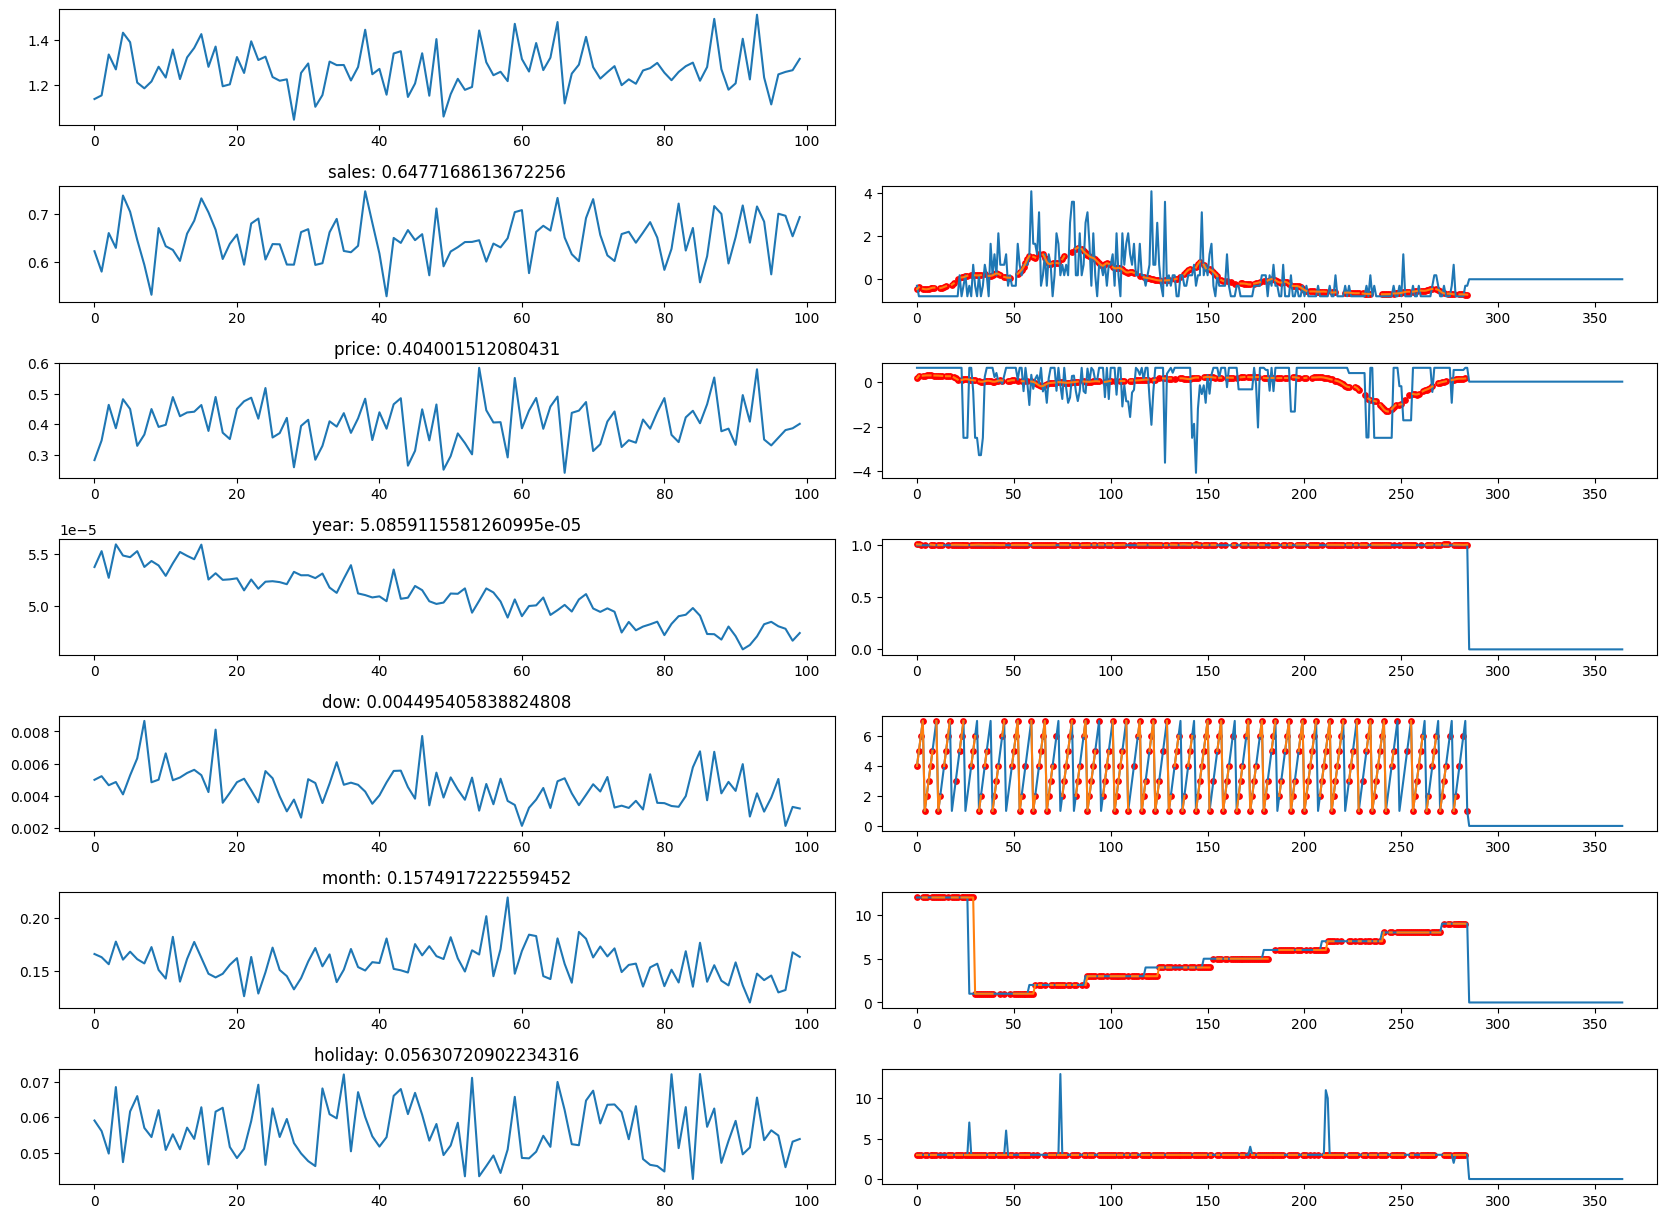

1 - loss: 1.2682936692237854, lr: [0.0009997532801828658]:  34%|███▎      | 308/919 [03:40<06:48,  1.49it/s]

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
mse_loss = torch.nn.MSELoss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")

def temporal_loss(col, pred, y, data, device):
    pred = pred.to(device).squeeze()
    y = y.to(device).squeeze()

    valid_idx = data["target_valid_idx"].squeeze().to(device)
    masked_idx = data[f"{col}_masked_idx"].squeeze().to(device)
    padding_mask = data[f"{col}_masked_padding_mask"].squeeze().to(device)

    valid_y = torch.gather(y, index=valid_idx, dim=1)
    masked_y = torch.gather(y, index=masked_idx, dim=1)

    if col in data_info.processing_info["embedding_cols"]:
        masked_idx = masked_idx.unsqueeze(-1).repeat(1, 1, pred.shape[-1])
        masked_pred = torch.gather(pred, index=masked_idx, dim=1)
        
        masked_pred = masked_pred.reshape(-1, masked_pred.shape[-1])
        masked_y = masked_y.reshape(-1)
        
        loss = ce_loss(masked_pred, masked_y.to(torch.long)).reshape(padding_mask.shape)
    
    elif col in data_info.processing_info["scaling_cols"]:
        masked_pred = torch.gather(pred, index=masked_idx, dim=1)
        
        loss = mse_loss(masked_pred, masked_y)
    
    loss = loss * padding_mask
    loss = sum(loss.view(-1)) / sum(padding_mask.view(-1))
    
    return loss

epoch = 10
for e in range(epoch):
    train(e)
    scheduler.step()